# JAV duomenų mokslo darbo skelbimų analizė.

In [1]:
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium import webdriver
import time
import pandas as pd
from selenium.webdriver.common.action_chains import ActionChains
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from dython import nominal
from sklearn.model_selection import train_test_split
import json
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import re

In [ ]:
import glassdoor_scraper as gs 

df = gs.get_jobs('data scientist', 2000, False)

df.to_csv('master_df.csv', index = False)

In [2]:
df_master = pd.read_csv('master_df.csv')

In [4]:
df_master.shape

(921, 14)

In [5]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          921 non-null    object 
 1   Salary Estimate    921 non-null    object 
 2   Job Description    921 non-null    object 
 3   Rating             600 non-null    float64
 4   Company Name       854 non-null    object 
 5   Location           921 non-null    object 
 6   Headquarters       600 non-null    object 
 7   Size               921 non-null    object 
 8   Founded            921 non-null    int64  
 9   Type of ownership  600 non-null    object 
 10  Industry           921 non-null    object 
 11  Sector             921 non-null    object 
 12  Revenue            921 non-null    object 
 13  Competitors        600 non-null    object 
dtypes: float64(1), int64(1), object(12)
memory usage: 57.6+ KB


In [6]:
df_master.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors'],
      dtype='object')

# Data Cleaning

1. Salaries

In [7]:
df_master = df_master[df_master['Salary Estimate'] != '-1']
df_master = df_master.reset_index()

In [8]:
df_master['hourly'] = df_master['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df_master['employer_provided'] = df_master['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary' in x.lower() else 0)

In [9]:
salary = df_master['Salary Estimate'].apply(lambda x: x.split('(')[0])
without_Kd = salary.apply(lambda x: x.replace('K', '').replace('$', ''))
pure_salary = without_Kd.apply(lambda x: x.lower().replace('employer provided salary:', '').replace('per hour', '').replace(' ', ''))

In [10]:
df_master['Min Salary'] = pure_salary.apply(lambda x: int(x.split('-')[0]))
df_master['Max Salary'] = pure_salary.apply(lambda x: int(x.split('-')[1]) if len(x) > 3 else int(x.split('-')[0]))

In [11]:
df_master['Average Salary'] = (df_master['Max Salary'] + df_master['Min Salary']) / 2

2. Extract ratings from Company names

In [12]:
rating = df_master['Company Name'].apply(lambda x : x[-3:] if x is not np.nan else x)

In [13]:
# function that return True if there are any numbers in string and returns False if number is abscent

def num_there(s):
    return any(i.isdigit() for i in s)

In [14]:
rating = rating.apply(lambda x : x if x is not np.nan and num_there(x) else '-1' )

In [15]:
df_master['Rating'] = rating

In [16]:
df_master['company_text'] = df_master.apply(lambda x: x['Company Name'] if float(x['Rating']) < 0 else x['Company Name'][:-3], axis = 1)
df_master['company_text'] = df_master['company_text'].apply(lambda x : x.replace('\n', '') if x is not np.nan else x)

3. Location. Split city and state into different columns

In [17]:
df_master['Location'] = df_master['Location'].apply(lambda x : x.replace('Remote', 'Remote, Remote'))

In [18]:
df_master['city'] = df_master['Location'].apply(lambda x : x.split(',')[0])
df_master['state'] = df_master['Location'].apply(lambda x : x.split(',')[1])
df_master['state'] = df_master['state'].apply(lambda x : x.replace(' ', ''))

In [19]:
df_master['state'] = df_master['state'].apply(lambda x : x.replace('LosAngeles', 'CA') if x =='LosAngeles' else x)

4. Column "Founded" change to company age

In [20]:
df_master['company_age'] = df_master['Founded'].apply(lambda x: (2022 - x) if x > 0 else x)

5. Get some information from description

In [21]:
# Python
df_master['python'] = df_master['Job Description'].apply(lambda x : 1 if 'python' in x.lower() else 0)
df_master['python'].value_counts()

1    466
0    295
Name: python, dtype: int64

In [22]:
# R Studio. There is way more than that. But because it is beeing used as 'R' in most description we can not get it. It will find all lerrer R.
df_master['r_studio'] = df_master['Job Description'].apply(lambda x : 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
df_master['r_studio'].value_counts()

0    755
1      6
Name: r_studio, dtype: int64

In [23]:
# SQL
df_master['sql'] = df_master['Job Description'].apply(lambda x : 1 if 'sql' in x.lower() else 0)
df_master['sql'].value_counts()

1    457
0    304
Name: sql, dtype: int64

In [24]:
# Javascript
df_master['javascript'] = df_master['Job Description'].apply(lambda x : 1 if 'javascript' in x.lower() else 0)
df_master['javascript'].value_counts()

0    727
1     34
Name: javascript, dtype: int64

In [25]:
# Spark
df_master['spark'] = df_master['Job Description'].apply(lambda x : 1 if 'spark' in x.lower() else 0)
df_master['spark'].value_counts()

0    599
1    162
Name: spark, dtype: int64

In [26]:
# Excel
df_master['excel'] = df_master['Job Description'].apply(lambda x : 1 if 'excel' in x.lower() else 0)
df_master['excel'].value_counts()

1    396
0    365
Name: excel, dtype: int64

In [27]:
# hadoop
df_master['hadoop'] = df_master['Job Description'].apply(lambda x : 1 if 'hadoop' in x.lower() else 0)
df_master['hadoop'].value_counts()

0    650
1    111
Name: hadoop, dtype: int64

In [28]:
# aws
df_master['aws'] = df_master['Job Description'].apply(lambda x : 1 if 'aws' in x.lower() else 0)
df_master['aws'].value_counts()

0    569
1    192
Name: aws, dtype: int64

In [29]:
# scala
df_master['scala'] = df_master['Job Description'].apply(lambda x : 1 if 'scala' in x.lower() else 0)
df_master['scala'].value_counts()

0    593
1    168
Name: scala, dtype: int64

In [30]:
# power bi
df_master['power_bi'] = df_master['Job Description'].apply(lambda x : 1 if 'power bi' in x.lower() else 0)
df_master['power_bi'].value_counts()

0    718
1     43
Name: power_bi, dtype: int64

In [31]:
# tableau
df_master['tableau'] = df_master['Job Description'].apply(lambda x : 1 if 'tableau' in x.lower() else 0)
df_master['tableau'].value_counts()

0    586
1    175
Name: tableau, dtype: int64

In [32]:
# machine learning
df_master['mle'] = df_master['Job Description'].apply(lambda x : 1 if 'machine learning' in x.lower() else 0)
df_master['mle'].value_counts()

0    457
1    304
Name: mle, dtype: int64

6. Get seniority

In [33]:
def seniority(title):
    if 'senior' in title.lower() or 'sr' in title.lower() or 'sr.' in title.lower() or 'lead' in title.lower() or 'chief' in title.lower() or 'principal' in title.lower() or 'director' in title.lower():
        return 'senior'
    elif 'jr.' in title.lower() or 'jr' in title.lower() or 'junior' in title.lower():
        return 'junior'
    else:
        return 'na'

In [34]:
df_master['seniority'] = df_master['Job Title'].apply(seniority)
df_master['seniority'].value_counts()

na        598
senior    139
junior     24
Name: seniority, dtype: int64

7. Normalise Job Titles

In [35]:
def title_norm(title):
    if 'data analyst' in title.lower() or 'analyst' in title.lower():
        return 'data analyst'
    elif 'scientist' in title.lower() or 'science' in title.lower() or 'data scientist' in title.lower():
        return 'data scientist'
    elif 'engineer' in title.lower():
        return 'data engineer'
    elif 'manager' in title.lower():
        return 'manager'
    else:
        return 'na'

In [36]:
df_master['job_title_norm'] = df_master['Job Title'].apply(title_norm)
df_master['job_title_norm'].value_counts()

data scientist    392
data engineer     176
data analyst      166
na                 20
manager             7
Name: job_title_norm, dtype: int64

In [37]:
df_master.columns

Index(['index', 'Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'Min Salary', 'Max Salary',
       'Average Salary', 'company_text', 'city', 'state', 'company_age',
       'python', 'r_studio', 'sql', 'javascript', 'spark', 'excel', 'hadoop',
       'aws', 'scala', 'power_bi', 'tableau', 'mle', 'seniority',
       'job_title_norm'],
      dtype='object')

8. Change hourly to yearly salary

In [38]:
df_master['Min Salary'] = df_master.apply(lambda x: x['Min Salary'] * 2 if x.hourly == 1 else x['Min Salary'], axis = 1)

In [39]:
df_master['Max Salary'] = df_master.apply(lambda x: x['Max Salary'] * 2 if x.hourly == 1 else x['Max Salary'], axis = 1)

In [40]:
df_master['Average Salary'] = df_master.apply(lambda x: x['Average Salary'] * 2 if x.hourly == 1 else x['Average Salary'], axis = 1)

9. Get the description length. Remove all "\n" in the text.

In [41]:
df_master['Job Description'][1]

'What You Will Do:\n\nI. General Summary\n\nThe Healthcare Data Scientist position will join our Advanced Analytics group at the University of Maryland Medical System (UMMS) in support of its strategic priority to become a data-driven and outcomes-oriented organization. The successful candidate will have 3+ years of experience with Machine Learning, Predictive Modeling, Statistical Analysis, Mathematical Optimization, Algorithm Development and a passion for working with healthcare data. Previous experience with various computational approaches along with an ability to demonstrate a portfolio of relevant prior projects is essential. This position will report to the UMMS Vice President for Enterprise Data and Analytics (ED&A).\n\nII. Principal Responsibilities and Tasks\n\n• Develops predictive and prescriptive analytic models in support of the organization’s clinical, operations and business initiatives and priorities.\n• Deploys solutions so that they provide actionable insights to the

In [42]:
df_master['Job Description'] = df_master['Job Description'].apply(lambda x : x.replace('\n\n', ' '))
df_master['Job Description'] = df_master['Job Description'].apply(lambda x : x.replace('\n', ''))
df_master['Job Description'] = df_master['Job Description'].apply(lambda x : x.replace('•', ''))
df_master['description_length'] = df_master["Job Description"].apply(lambda x : len(x))

In [43]:
df_master['Job Description'][1]

'What You Will Do: I. General Summary The Healthcare Data Scientist position will join our Advanced Analytics group at the University of Maryland Medical System (UMMS) in support of its strategic priority to become a data-driven and outcomes-oriented organization. The successful candidate will have 3+ years of experience with Machine Learning, Predictive Modeling, Statistical Analysis, Mathematical Optimization, Algorithm Development and a passion for working with healthcare data. Previous experience with various computational approaches along with an ability to demonstrate a portfolio of relevant prior projects is essential. This position will report to the UMMS Vice President for Enterprise Data and Analytics (ED&A). II. Principal Responsibilities and Tasks  Develops predictive and prescriptive analytic models in support of the organization’s clinical, operations and business initiatives and priorities. Deploys solutions so that they provide actionable insights to the organization an

 # EDA

First of all I am going to split data into categorical and numerical data.


1. histograms
2. correlations (categorical data vs categorical data then use chi square, cramers v. If categorcial vs continiuous then point biserial correlation or correlation ratio)
2. box plots
3. categorical data, pivot tables with avg_salary
4. word cloud

In [44]:
numerical = ['Average Salary', 'Rating', 'company_age', 'description_length']
categorical = ['Size', 'Industry', 'Sector', 'Revenue', 'hourly', 'employer_provided', 'company_text', 'city', 'state', 'python', 'r_studio',
                'sql', 'javascript', 'spark', 'excel', 'hadoop', 'aws', 'scala', 'power_bi', 'tableau', 'seniority', 'job_title_norm', 'mle']

Histograms of continuous data: Founded, Rating, Company age, job desciprion length, average salary

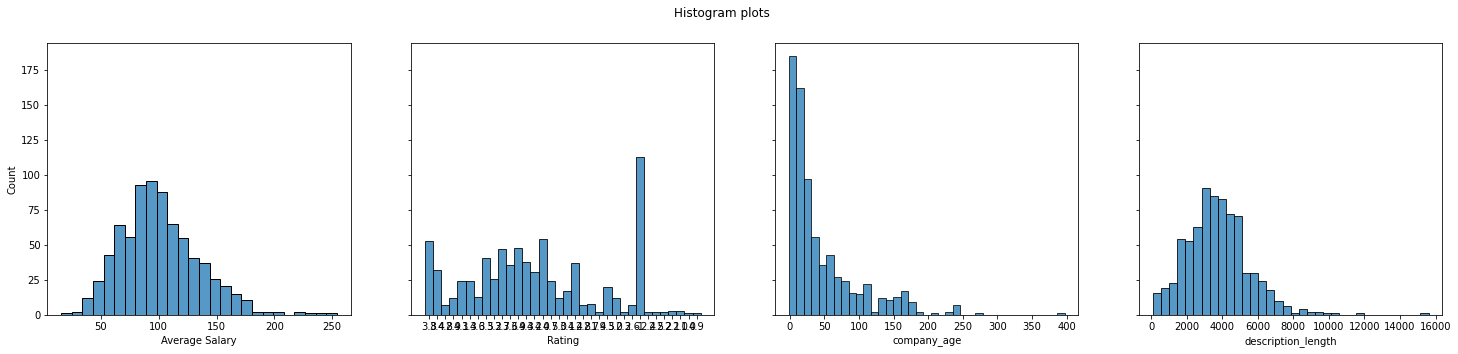

In [45]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5), sharey=True)
fig.suptitle('Histogram plots')

for i in range(len(numerical)):
    sns.histplot(ax = axes[i],data = df_master, x = numerical[i])


Average salary and description length are normaly distributed. <br>
Company age looks like have an exponencial distribution and rating have??<br>
We can tell most of the companies are up to 50 years old. And we have a few outliers on the description lenght


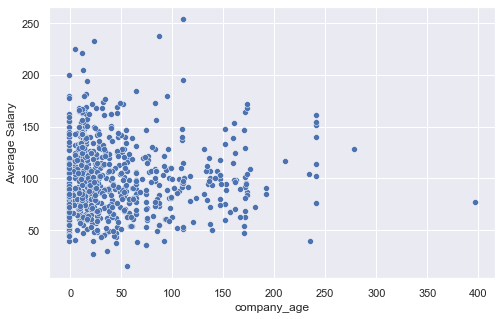

In [46]:
sns.set(rc={"figure.figsize": [8, 5]})
sns.scatterplot(x=df_master['company_age'], y=df_master['Average Salary']);

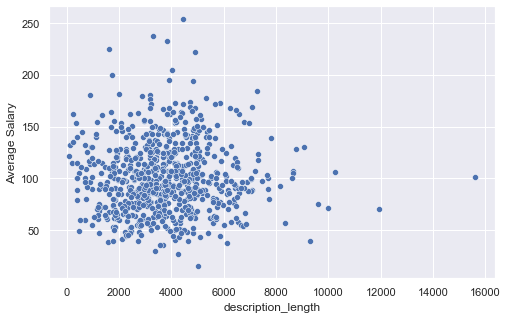

In [47]:
sns.set(rc={"figure.figsize": [8, 5]})
sns.scatterplot(x=df_master['description_length'], y=df_master['Average Salary']);

It seems that there is no correlation between avg salary and desc length or company age.

2. Box plots. Find if we have many outliers

In [48]:
cat = ['Sector', 'Revenue', 'hourly', 'employer_provided', 'state', 'python', 'r_studio',
                'sql', 'javascript', 'spark', 'excel', 'hadoop', 'aws', 'scala', 'power_bi', 'tableau', 'seniority', 'job_title_norm', 'mle']

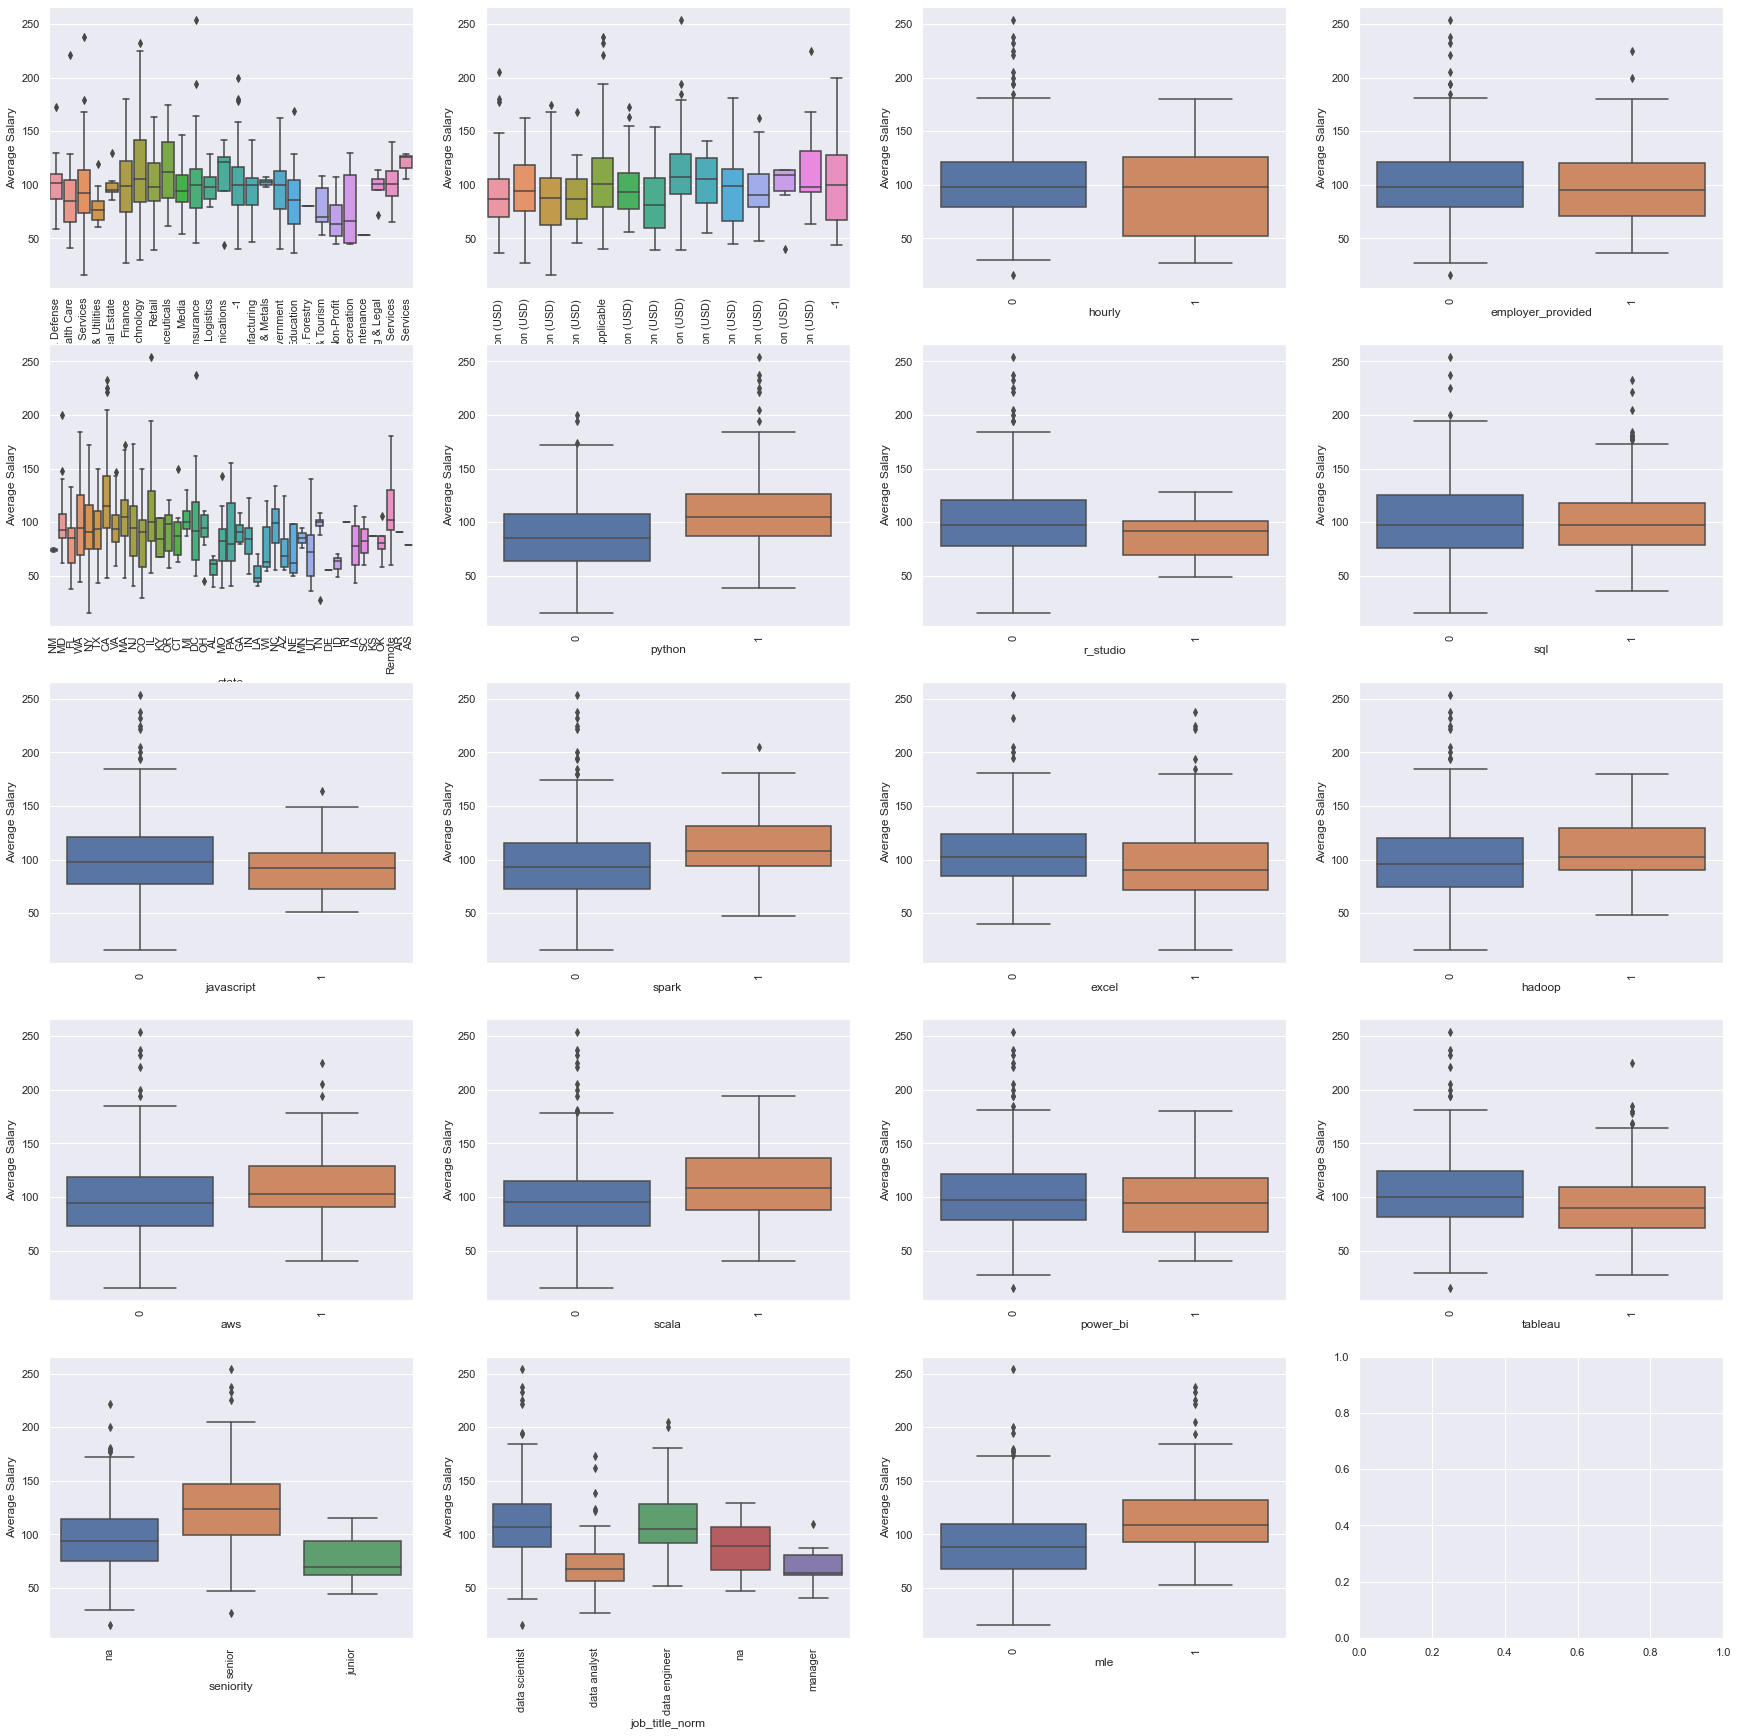

In [49]:
fig, ax = plt.subplots(5, 4, figsize=(30, 30))
for var, subplot in zip(cat, ax.flatten()):
    sns.boxplot(x=var, y='Average Salary', data=df_master, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

We could see that:<br>
1. People with Python, Spark, Scala, Machine learning, aws, hadoop are getting paid more <br>
2. Obviously senior positions are paid better.<br>
3. Data scientists and data engineers are getting paid more than data analysts.

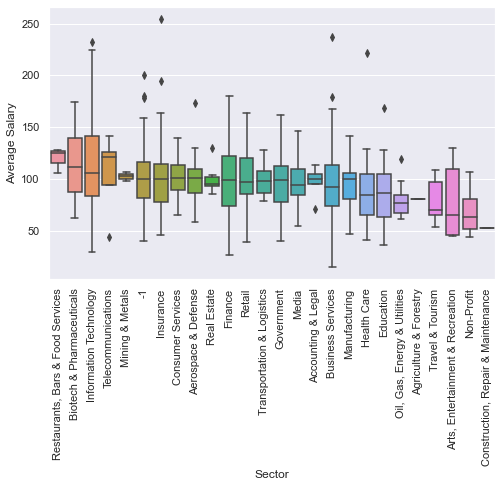

In [50]:
sorted_sc = df_master.groupby(['Sector'])['Average Salary'].mean().sort_values(ascending=False)
ax = sns.boxplot(x=df_master['Sector'], y=df_master['Average Salary'], order=list(sorted_sc.index))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Biotech and information technology sectors are paying more on average.

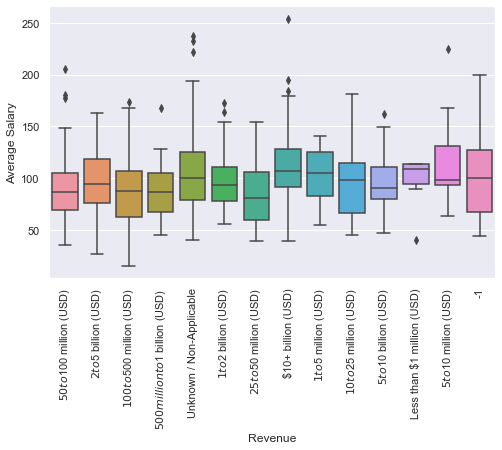

In [51]:
ax = sns.boxplot(x='Revenue', y='Average Salary', data=df_master)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

As we could expect big corporations (Revenue is over 10 billion) are paying more. But also small companies (5-10 million, 1-5million)

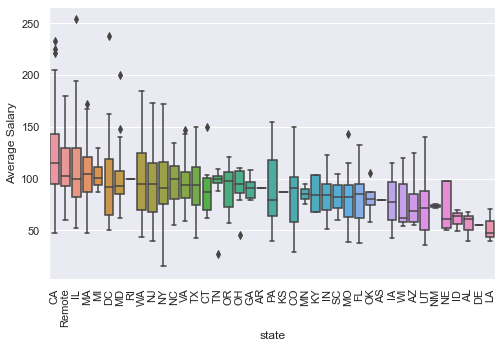

In [52]:
sorted_sc = df_master.groupby(['state'])['Average Salary'].mean().sort_values(ascending=False)
ax = sns.boxplot(x=df_master['state'], y=df_master['Average Salary'], order=list(sorted_sc.index))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

1. The highest average salaries are in California, Illinois and Massachusetts.
2. The lowest average salaries are in Los Angeles, Delaware and Alabama.

In [53]:
cat_df = df_master[['Industry', 'Sector', 'Revenue', 'hourly', 'employer_provided', 'city', 'state', 'python', 'r_studio', 'sql', 'javascript', 'spark', 'excel', 'hadoop', 'aws', 'scala', 'power_bi','tableau','seniority','job_title_norm', 'mle']]

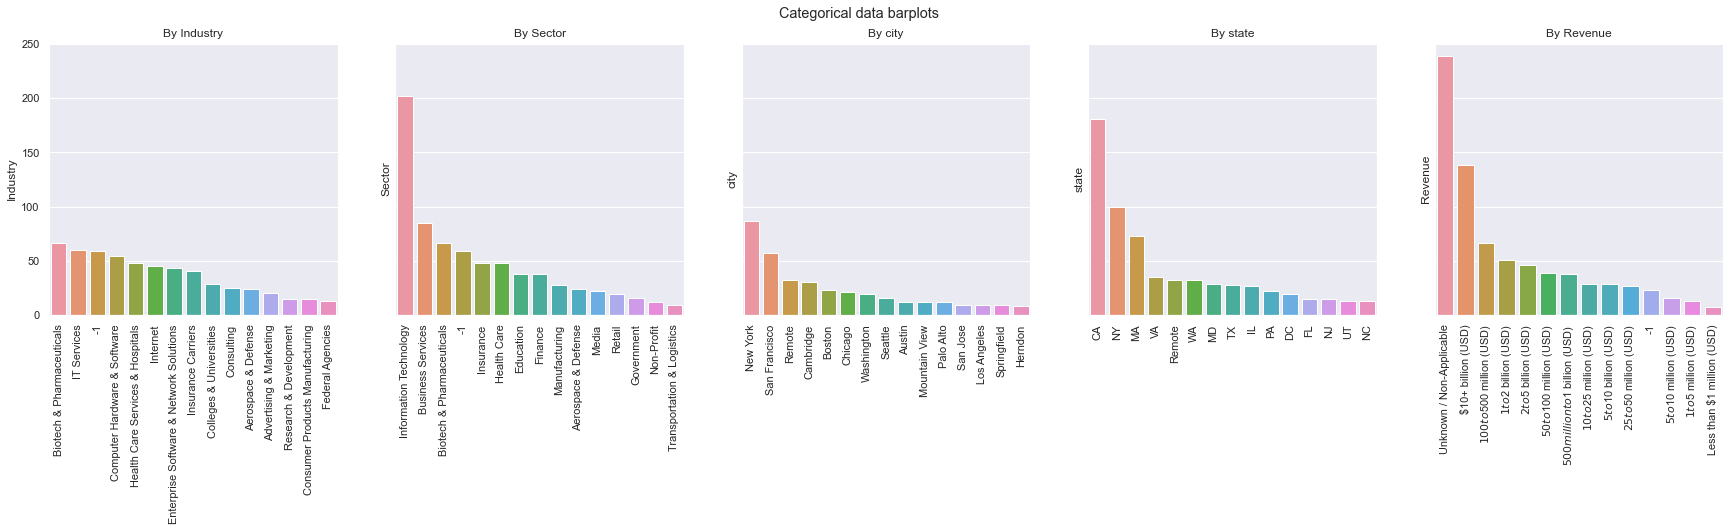

In [54]:
temp_df = cat_df[['Industry','Sector', 'city', 'state', 'Revenue']]

fig, axes = plt.subplots(1,5, figsize=(30,5), sharey = True)
fig.suptitle('Categorical data barplots')

for i in temp_df.columns:
    g = temp_df[i].value_counts()[:15]
    sns.barplot(ax=axes[temp_df.columns.get_loc(i)], x=g.index, y = g)
    axes[temp_df.columns.get_loc(i)].set_title(f'By {i}')
    axes[temp_df.columns.get_loc(i)].set_xticklabels(axes[temp_df.columns.get_loc(i)].get_xticklabels(), rotation=90);



Biontech and information technology companies are hiring the most. <br>
New York city and San Francisco are looking the most people in data science, data analysis or data engineering (Can lookup which is the most popular)

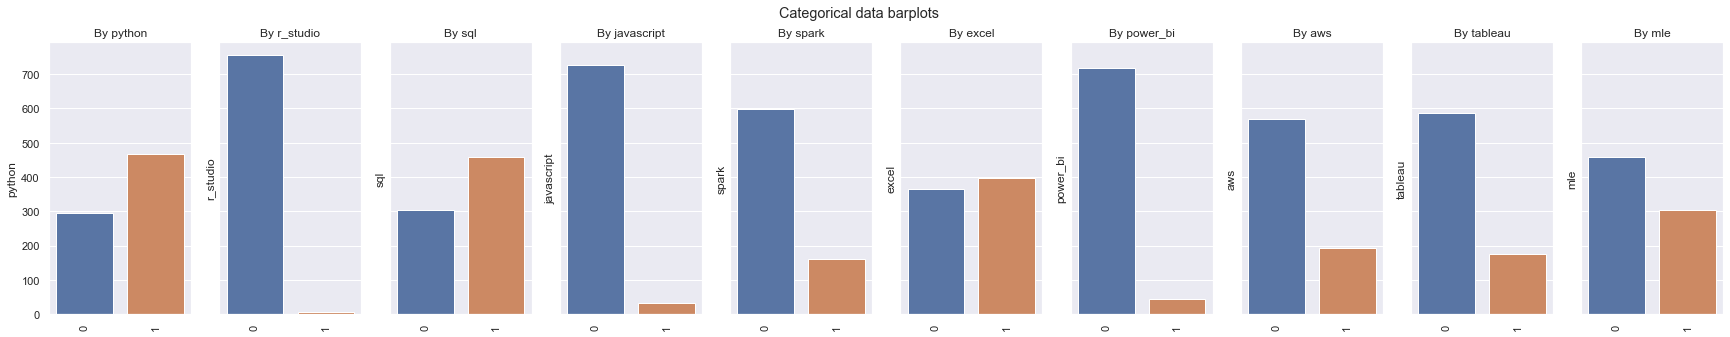

In [55]:
temp_df = cat_df[['python','r_studio', 'sql', 'javascript', 'spark', 'excel', 'power_bi', 'aws', 'tableau','mle']]

fig, axes = plt.subplots(1,10, figsize=(30,5), sharey = True)
fig.suptitle('Categorical data barplots')

for i in temp_df.columns:
    g = temp_df[i].value_counts()[:15]
    sns.barplot(ax=axes[temp_df.columns.get_loc(i)], x=g.index, y = g)
    axes[temp_df.columns.get_loc(i)].set_title(f'By {i}')
    axes[temp_df.columns.get_loc(i)].set_xticklabels(axes[temp_df.columns.get_loc(i)].get_xticklabels(), rotation=90);

1. Python, SQL, Machine Learning, Excel are the most required programing languages. 

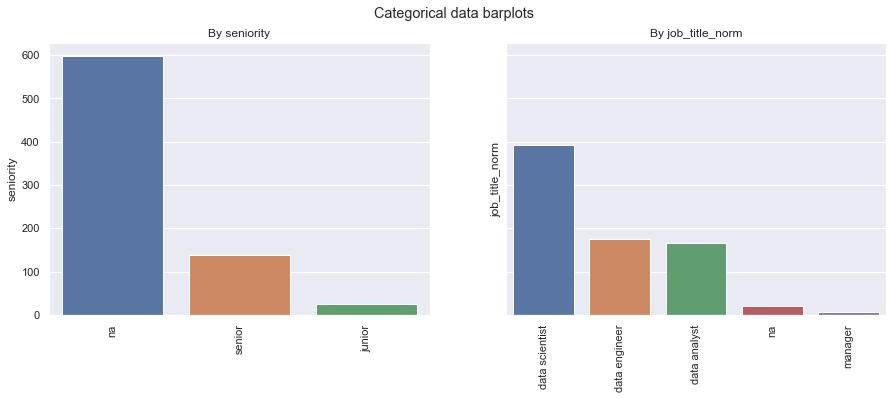

In [56]:
temp_df = cat_df[['seniority','job_title_norm']]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey = True)
fig.suptitle('Categorical data barplots')

for i in temp_df.columns:
    g = temp_df[i].value_counts()[:15]
    sns.barplot(ax=axes[temp_df.columns.get_loc(i)], x=g.index, y = g)
    axes[temp_df.columns.get_loc(i)].set_title(f'By {i}')
    axes[temp_df.columns.get_loc(i)].set_xticklabels(axes[temp_df.columns.get_loc(i)].get_xticklabels(), rotation=90);

1. Companies are looking for more senior positions than junior. <br>
2. Companies are looking for more data scientists than data engineers or data analysts. <br>
3. This could be a wrong data, because I couldnt get more data from glassdooor.

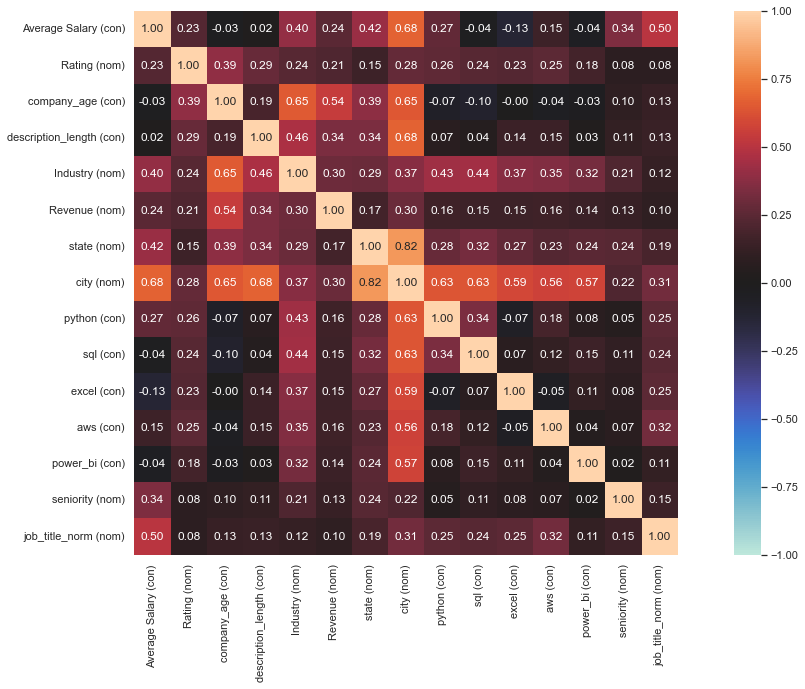

In [57]:
cont_corr_df = df_master[['Average Salary', 'Rating', 'company_age', 'description_length', 'Industry', 'Revenue', 'state', 'city','python', 'sql', 'excel', 'aws', 'power_bi', 'seniority', 'job_title_norm']]
nominal.associations(cont_corr_df,figsize=(20,10),mark_columns=True);

5. Pivot tables with average salary

In [58]:
# Data engineers gets paid the most
pd.pivot_table(df_master, index = 'job_title_norm', values = 'Average Salary')

,Average Salary
job_title_norm,
data analyst,70.222892
data engineer,111.494318
data scientist,110.436224
manager,71.428571
na,87.475000


In [59]:
pd.pivot_table(df_master, index = ['job_title_norm', 'seniority'], values = 'Average Salary')

Average Salary
job_title_norm seniority                
data analyst   junior          62.133333
               na              69.184211
               senior          84.638889
data engineer  junior         115.000000
               na             109.493333
               senior         123.360000
data scientist junior          98.312500
               na             103.408621
               senior         133.148936
manager        na              71.428571
na             na              86.722222
               senior          94.250000

In [60]:
pd.pivot_table(df_master, index = 'state', values = 'Average Salary').sort_values('Average Salary', ascending=False)

,Average Salary
state,
CA,119.726519
Remote,110.000000
IL,109.592593
MA,105.143836
MI,104.500000
DC,100.815789
MD,100.310345
RI,100.000000
WA,98.578125


In [61]:
## best paid junior position jobs are in California

pd.pivot_table(df_master[df_master['seniority'] == 'junior'], index = 'state', values = 'Average Salary').sort_values('Average Salary', ascending=False)

,Average Salary
state,
CA,97.333333
NY,94.750000
Remote,92.500000
VA,83.000000
MD,76.500000
OK,73.166667
IN,71.000000
DC,61.500000
WA,59.666667


In [62]:
# Best paid senior positions are in DC

pd.pivot_table(df_master[df_master['seniority'] == 'senior'], index = 'state', values = 'Average Salary').sort_values('Average Salary', ascending=False)

,Average Salary
state,
DC,237.500000
IL,152.222222
CA,148.465517
UT,140.500000
MA,130.045455
NJ,127.625000
MD,124.600000
WA,123.166667
Remote,120.000000


In [63]:
# You will get paid more if you can code with Python!
pd.pivot_table(df_master, index = 'python', values = 'Average Salary')

,Average Salary
python,
0,89.572881
1,108.146996


In [64]:
pd.pivot_table(df_master, index = 'excel', values = 'Average Salary')

,Average Salary
excel,
0,105.575342
1,96.680556


In [65]:
# THis is probably for data engineers.

pd.pivot_table(df_master, index = 'aws', values = 'Average Salary')

,Average Salary
aws,
0,97.905097
1,109.960938


In [66]:
pd.pivot_table(df_master, index = 'mle', values = 'Average Salary')

,Average Salary
mle,
0,92.070022
1,114.291118


In [67]:
pd.pivot_table(df_master, index = 'sql', values = 'Average Salary')

,Average Salary
sql,
0,102.449013
1,99.947484


In [68]:
pd.pivot_table(df_master, index = 'spark', values = 'Average Salary')

,Average Salary
spark,
0,97.523372
1,113.604938


In [69]:
pd.pivot_table(df_master, index = 'power_bi', values = 'Average Salary')

,Average Salary
power_bi,
0,101.298747
1,95.069767


7. Lets do something with job description. Word cloud is a perfect way to see which words are used the most in the job descripions.

In [70]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vytau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

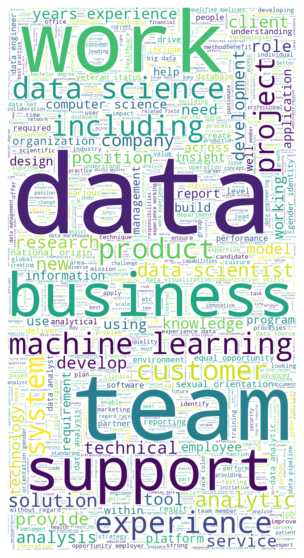

In [71]:
words = " ".join(df_master['Job Description'])

def punctuation_stop(text):
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


words_filtered = punctuation_stop(words)

text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


# Data modelling

1. multiple linear regression
2. xgboost


In [72]:
df_master.columns

Index(['index', 'Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'Min Salary', 'Max Salary',
       'Average Salary', 'company_text', 'city', 'state', 'company_age',
       'python', 'r_studio', 'sql', 'javascript', 'spark', 'excel', 'hadoop',
       'aws', 'scala', 'power_bi', 'tableau', 'mle', 'seniority',
       'job_title_norm', 'description_length'],
      dtype='object')

In [73]:
df_master.describe()

,index,Founded,hourly,employer_provided,Min Salary,Max Salary,Average Salary,company_age,python,r_studio,...,javascript,spark,excel,hadoop,aws,scala,power_bi,tableau,mle,description_length
count,761.000000,761.000000,761.000000,761.000000,761.00000,761.000000,761.000000,761.000000,761.000000,761.000000,...,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,472.473062,1679.667543,0.057819,0.157687,74.90933,126.984231,100.946781,44.450723,0.612352,0.007884,...,0.044678,0.212878,0.520368,0.145861,0.252300,0.220762,0.056505,0.229961,0.399474,3737.703022
std,271.997576,700.399708,0.233554,0.364687,28.51977,42.075806,33.971691,53.081125,0.487534,0.088501,...,0.206732,0.409611,0.499914,0.353199,0.434618,0.415033,0.231045,0.421084,0.490112,1751.431141
min,0.000000,-1.000000,0.000000,0.000000,15.00000,16.000000,15.500000,-1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,97.000000
25%,235.000000,1905.000000,0.000000,0.000000,55.00000,98.000000,77.500000,10.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2586.000000
50%,488.000000,1981.000000,0.000000,0.000000,70.00000,123.000000,97.500000,24.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3663.000000
75%,713.000000,2006.000000,0.000000,0.000000,90.00000,150.000000,121.000000,60.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4721.000000
max,920.000000,2020.000000,1.000000,1.000000,202.00000,306.000000,254.000000,397.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15607.000000


In [75]:
df_model = df_master[['Average Salary', 'hourly', 'employer_provided', 'company_age', 'python', 'excel', 'aws', 'Size', 'Industry', 'Revenue', 'company_text', 'city', 'state', 'sql', 'spark', 'seniority', 
                        'job_title_norm', 'mle','description_length']]

In [76]:
df_dummies = pd.get_dummies(df_model)

In [77]:
X = df_dummies.drop('Average Salary', axis = 1)
y = df_dummies['Average Salary'].values

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [80]:
df_dummies.columns

Index(['Average Salary', 'hourly', 'employer_provided', 'company_age',
       'python', 'excel', 'aws', 'sql', 'spark', 'mle',
       ...
       'state_WA', 'state_WI', 'seniority_junior', 'seniority_na',
       'seniority_senior', 'job_title_norm_data analyst',
       'job_title_norm_data engineer', 'job_title_norm_data scientist',
       'job_title_norm_manager', 'job_title_norm_na'],
      dtype='object', length=937)